In [80]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler,MinMaxScaler
import numpy as np
import tensorflow as tf
from tensorflow import keras
from keras import models,layers
from keras.models import Sequential
from keras.layers import LSTM,Dense,Dropout
from keras.utils import plot_model
from sklearn.metrics import mean_squared_error

# **Read and plotting the data**

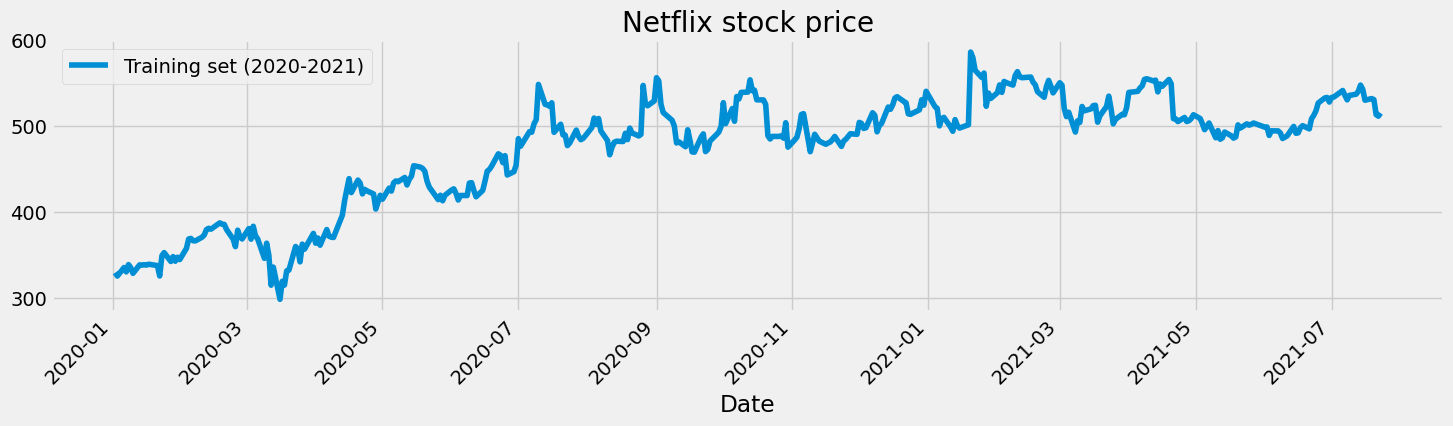

In [52]:
# read the dataset
Data=pd.read_csv("/content/NFLX.csv")
Data.head(-1)


# Convert the 'Date' column to datetime if it's not already
if Data['Date'].dtype != 'datetime64[ns]':
    Data['Date'] = pd.to_datetime(Data['Date'])


# Set the 'Date' column as the index
Data.set_index('Date', inplace=True)

#Plotting
plt.figure(figsize=(10, 5))
Data['Close']['2020':'2021-07-25'].plot(figsize=(16, 4), legend=True)
plt.xticks(rotation=45)
plt.legend(['Training set (2020-2021)'])
plt.title('Netflix stock price')
plt.show()

# **Assign Data for training & testing**

In [53]:
Train_set = Data.loc['2020-03-10':'2021-07-25', 'Close'].values # Use .loc to slice by dates
Test_set = Data.loc['2021-07-25':, 'Close'].values
S=MinMaxScaler(feature_range=(-1,1))
scaled_train = S.fit_transform(Train_set.reshape(-1,1))
scaled_test = S.transform(Test_set.reshape(-1,1))

## **Take last 20 elements from train set for testing**

In [54]:
#Handling Sequential Dependencies
Test_set_to_prediction=np.concatenate([scaled_train[-21:],scaled_test],axis=0)

# **Prepare the data for Training a model**

In [55]:
window_size = 3
def windowed_dataset(series,batch_size):
    dataset = tf.data.Dataset.from_tensor_slices(series.reshape(-1,1))
    dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)
    dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))
    dataset = dataset.map(lambda window: (window[:-1], window[-1]))
    dataset = dataset.batch(len(series)).prefetch(1)
    return dataset

# **Extract input features and target values from training set windows**

In [56]:
X,y=np.array(list(windowed_dataset(scaled_train,10))[0][0]),np.array(list(windowed_dataset(scaled_train,10))[0][1])

# **Extract input features and target values from testing set windows**

In [57]:
X_test,y_test=np.array(list(windowed_dataset(Test_set_to_prediction,10))[0][0]),np.array(list(windowed_dataset(Test_set_to_prediction,10))[0][1])

# **LSTM MODEL**

In [58]:
Lstm_Model=Sequential(
[
    LSTM(units=60,input_shape=(X.shape[1],1),return_sequences=True),
    LSTM(units=50,return_sequences=True),
    LSTM(units=30,return_sequences=True),
    LSTM(units=20,return_sequences=True),
    LSTM(10),
    Dense(units=1),
])

Lstm_Model.summary()

Lstm_Model.compile(optimizer = "adam",loss='mean_squared_error')


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_30 (LSTM)                       │ (None, 3, 60)               │          14,880 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_31 (LSTM)                       │ (None, 3, 50)               │          22,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_32 (LSTM)                       │ (None, 3, 30)               │           9,720 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_33 (LSTM)                       │ (None, 3, 20)               │           4,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_34 (LSTM)                       │ (None, 10)                  │           1,240 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 1)                   │              11 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 52,131 (203.64 KB)

 Trainable params: 52,131 (203.64 KB)

 Non-trainable params: 0 (0.00 B)

# **Callback Function**

In [61]:
class myCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        logs = logs or {}
        if logs.get('loss') is not None and logs.get('loss') < 0.01:  # Check validation loss
            print("\nReached desired validation loss so cancelling training!")
            self.model.stop_training = True

# **Train the Model**

In [62]:
callbacks = myCallback()
history= Lstm_Model.fit(X,y,epochs=10,callbacks=[callbacks], verbose = 2)

Epoch 1/10
11/11 - 0s - 13ms/step - loss: 0.0236
Epoch 2/10
11/11 - 0s - 14ms/step - loss: 0.0213
Epoch 3/10
11/11 - 0s - 13ms/step - loss: 0.0196
Epoch 4/10
11/11 - 0s - 15ms/step - loss: 0.0183
Epoch 5/10
11/11 - 0s - 25ms/step - loss: 0.0174
Epoch 6/10
11/11 - 0s - 13ms/step - loss: 0.0166
Epoch 7/10
11/11 - 0s - 13ms/step - loss: 0.0159
Epoch 8/10
11/11 - 0s - 15ms/step - loss: 0.0158
Epoch 9/10
11/11 - 0s - 27ms/step - loss: 0.0157
Epoch 10/10
11/11 - 0s - 26ms/step - loss: 0.0148


# **Plotting Model loss**

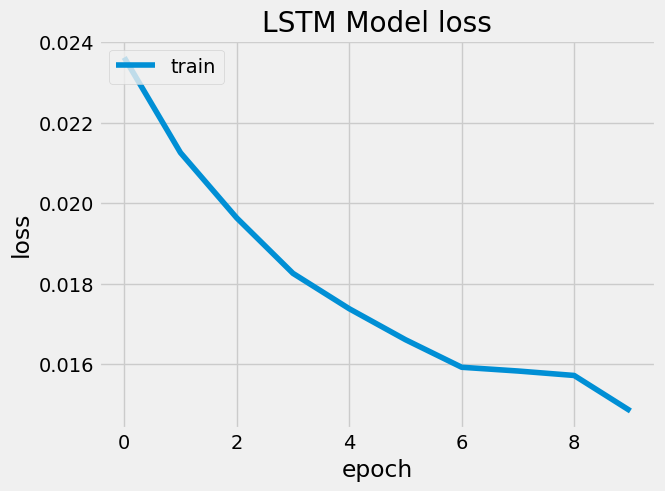

In [83]:
plt.plot(history.history['loss'])
plt.title('LSTM Model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train'], loc='upper left')
plt.show()

In [64]:
Lstm_Model.evaluate(X_test,y_test)

5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0998  


0.14750570058822632

# **Model make predictions based on testing data**

In [65]:
FIN_LSTM=Lstm_Model.predict(X_test)

5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 206ms/step


# **Comparing the Result between prediction and actual data**

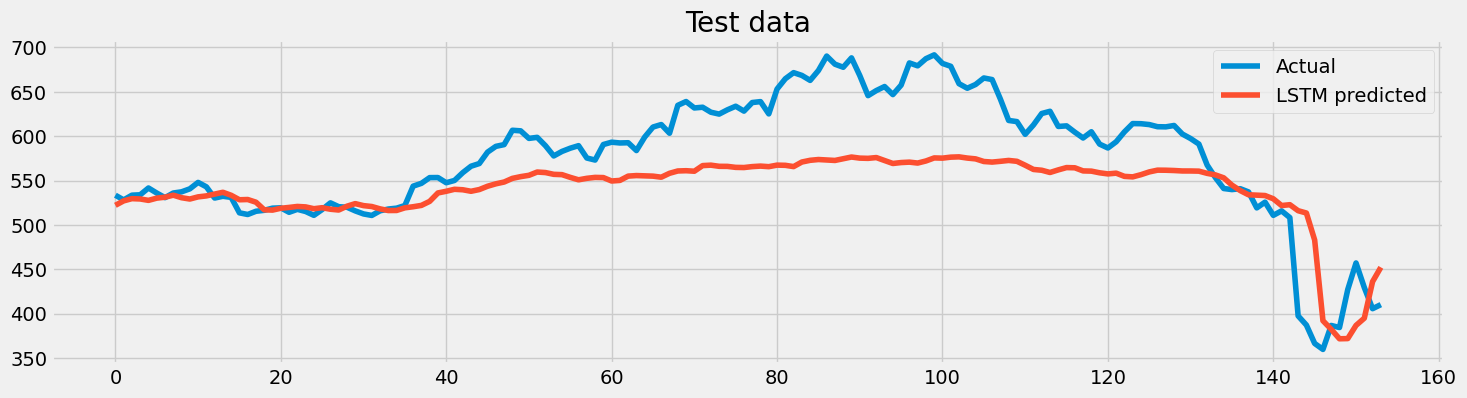

In [81]:
x=np.arange(0,len(y_test))
plt.figure(figsize=(16,4))
plt.title("Test data",fontsize=20)
plt.plot(x,S.inverse_transform(y_test),label="Actual")
plt.plot(x,S.inverse_transform(FIN_LSTM),label="LSTM predicted")
plt.legend()
plt.show()

In [67]:
##Model Definition with GRU
model_gru = tf.keras.Sequential([
    tf.keras.layers.GRU(60, input_shape=(X.shape[1], 1), return_sequences=True),
    tf.keras.layers.GRU(50, return_sequences=True),
   (tf.keras.layers.GRU(30, return_sequences=True)),
    tf.keras.layers.GRU(20, return_sequences=True),
    tf.keras.layers.GRU(10),
    tf.keras.layers.Dense(1)])


# Set the training parameters
model_gru.compile(optimizer = "adam",loss='mean_squared_error')

# Print the model summary
model_gru.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ gru_5 (GRU)                          │ (None, 3, 60)               │          11,340 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ gru_6 (GRU)                          │ (None, 3, 50)               │          16,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ gru_7 (GRU)                          │ (None, 3, 30)               │           7,380 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ gru_8 (GRU)                          │ (None, 3, 20)               │           3,120 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ gru_9 (GRU)                          │ (None, 10)                  │             960 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ (None, 1)                   │              11 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 39,611 (154.73 KB)

 Trainable params: 39,611 (154.73 KB)

 Non-trainable params: 0 (0.00 B)

In [68]:
callbacks = myCallback()
history1= model_gru.fit(X,y,epochs=10,callbacks=[callbacks], verbose = 2)

Epoch 1/10
11/11 - 11s - 1s/step - loss: 0.1700
Epoch 2/10
11/11 - 0s - 14ms/step - loss: 0.0729
Epoch 3/10
11/11 - 0s - 13ms/step - loss: 0.0403
Epoch 4/10
11/11 - 0s - 14ms/step - loss: 0.0172
Epoch 5/10
11/11 - 0s - 28ms/step - loss: 0.0151
Epoch 6/10
11/11 - 0s - 14ms/step - loss: 0.0132
Epoch 7/10
11/11 - 0s - 14ms/step - loss: 0.0130
Epoch 8/10
11/11 - 0s - 14ms/step - loss: 0.0130
Epoch 9/10
11/11 - 0s - 14ms/step - loss: 0.0125
Epoch 10/10
11/11 - 0s - 14ms/step - loss: 0.0127


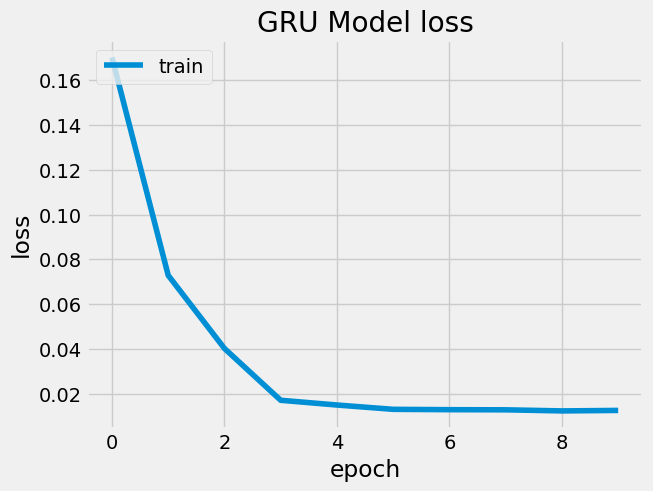

In [82]:
plt.plot(history1.history['loss'])
plt.title('GRU Model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train'], loc='upper left')
plt.show()

In [70]:
model_gru.evaluate(X_test,y_test)

5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0814


0.11968813091516495

In [71]:
FIN_gru=model_gru.predict(X_test)

5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 253ms/step


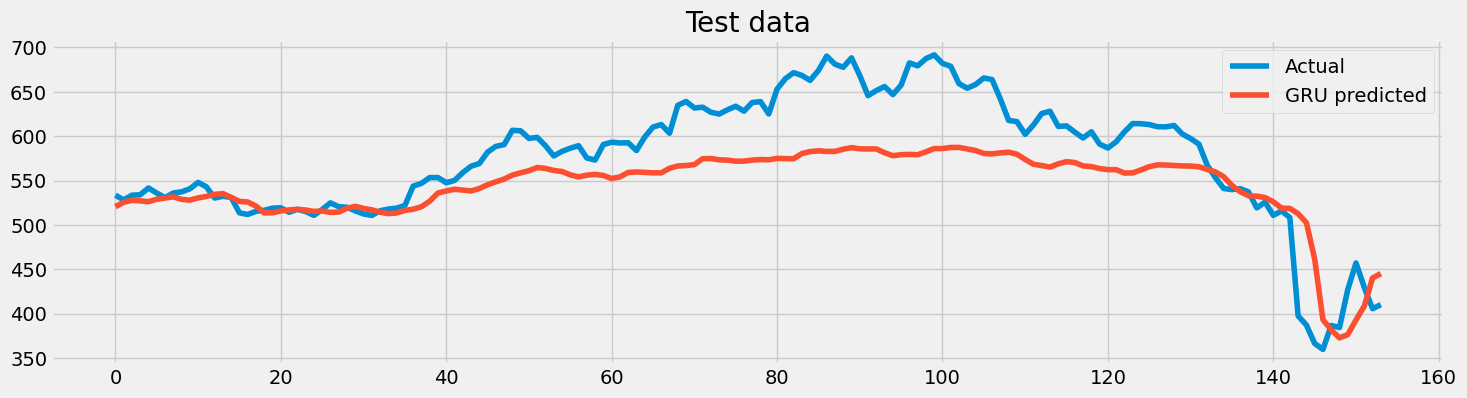

In [84]:
x=np.arange(0,len(y_test))
plt.figure(figsize=(16,4))
plt.title("Test data",fontsize=20)
plt.plot(x,S.inverse_transform(y_test),label="Actual")
plt.plot(x,S.inverse_transform(FIN_gru),label="GRU predicted")
plt.legend()
plt.show()

# **BIDirectional LSTM**

In [73]:
import tensorflow as tf

# Assuming X.shape[1] is the number of timesteps in your input data
# and X.shape[2] is the number of features (e.g., 1 if univariate).

model_BI = tf.keras.Sequential([
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(60, return_sequences=True), input_shape=(X.shape[1], X.shape[2])),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(50, return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(30, return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(20, return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(10)),
    tf.keras.layers.Dense(1)
])

# Set the training parameters
model_BI.compile(optimizer="adam", loss='mean_squared_error')

# Print the model summary
model_BI.summary()


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ bidirectional_25 (Bidirectional)     │ (None, 3, 120)              │          29,760 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_26 (Bidirectional)     │ (None, 3, 100)              │          68,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_27 (Bidirectional)     │ (None, 3, 60)               │          31,440 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_28 (Bidirectional)     │ (None, 3, 40)               │          12,960 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_29 (Bidirectional)     │ (None, 20)                  │           4,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_9 (Dense)                      │ (None, 1)                   │              21 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 146,661 (572.89 KB)

 Trainable params: 146,661 (572.89 KB)

 Non-trainable params: 0 (0.00 B)

In [74]:
callbacks = myCallback()
history2= model_BI.fit(X,y,epochs=10,callbacks=[callbacks], verbose = 2)

Epoch 1/10
11/11 - 19s - 2s/step - loss: 0.2032
Epoch 2/10
11/11 - 0s - 21ms/step - loss: 0.0925
Epoch 3/10
11/11 - 0s - 30ms/step - loss: 0.0525
Epoch 4/10
11/11 - 0s - 24ms/step - loss: 0.0277
Epoch 5/10
11/11 - 0s - 26ms/step - loss: 0.0119
Epoch 6/10
11/11 - 0s - 22ms/step - loss: 0.0122
Epoch 7/10

Reached desired validation loss so cancelling training!
11/11 - 0s - 43ms/step - loss: 0.0100


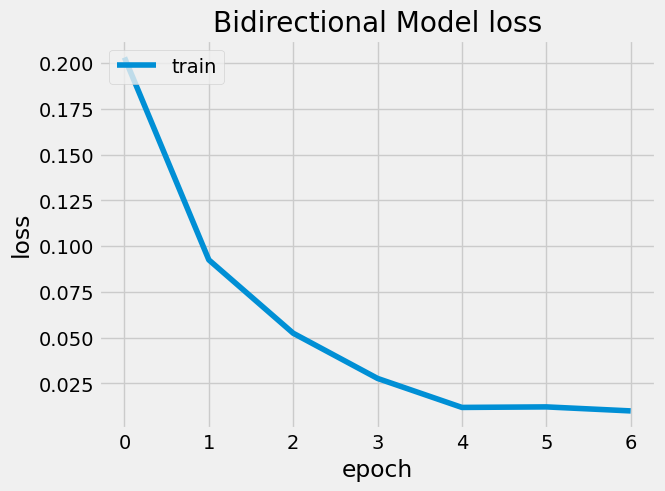

In [85]:
plt.plot(history2.history['loss'])
plt.title('Bidirectional Model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train'], loc='upper left')
plt.show()

In [76]:
model_BI.evaluate(X_test,y_test)

5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0907


0.13142713904380798

In [77]:
FIN_BI=model_BI.predict(X_test)

5/5 ━━━━━━━━━━━━━━━━━━━━ 4s 440ms/step


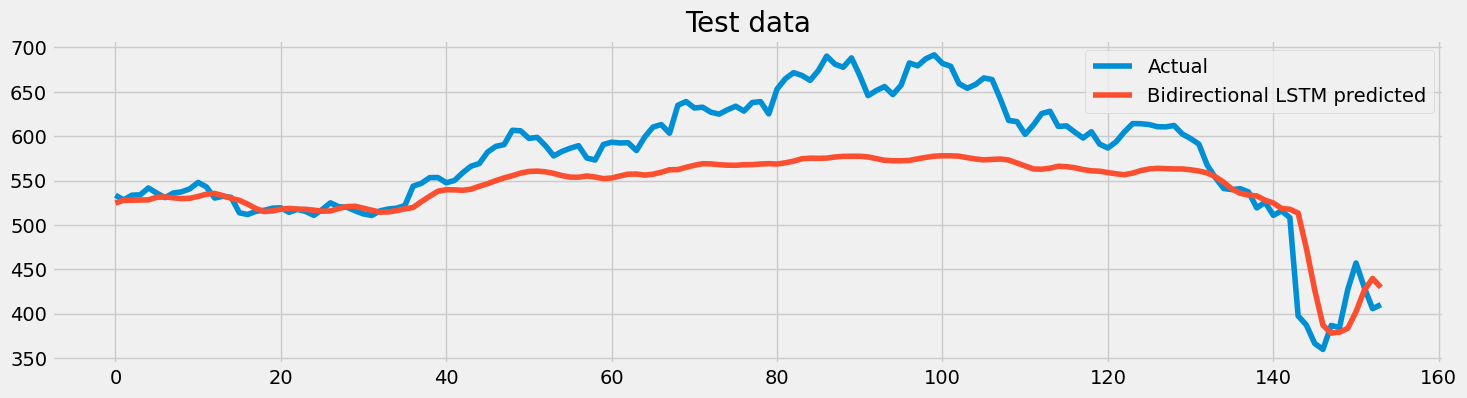

In [86]:
x=np.arange(0,len(y_test))
plt.figure(figsize=(16,4))
plt.title("Test data",fontsize=20)
plt.plot(x,S.inverse_transform(y_test),label="Actual")
plt.plot(x,S.inverse_transform(FIN_BI),label="Bidirectional LSTM predicted")
plt.legend()
plt.show()

# **Plotting 3 Models**

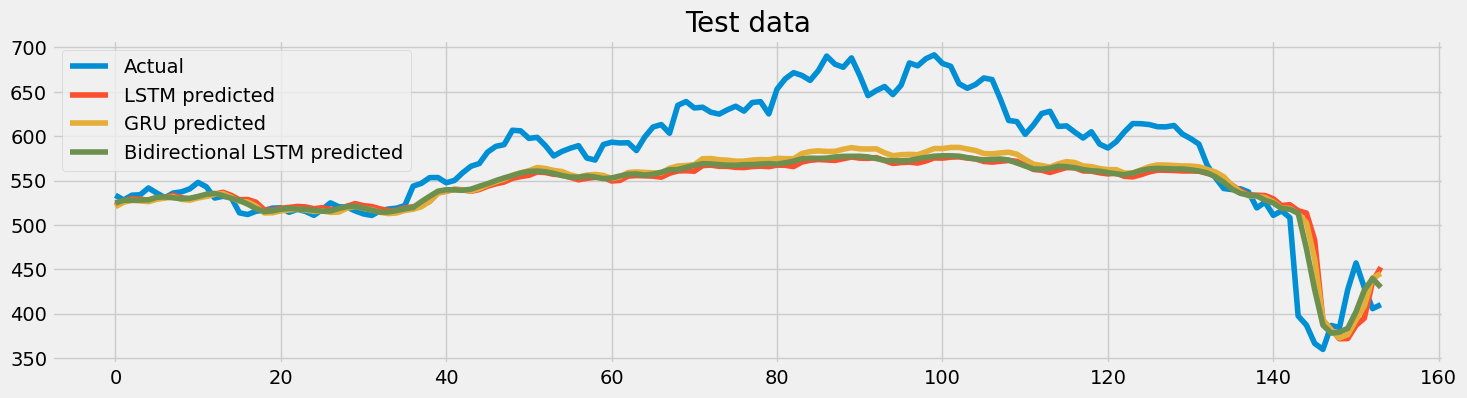

In [87]:
x=np.arange(0,len(y_test))
plt.figure(figsize=(16,4))
plt.title("Test data",fontsize=20)
plt.plot(x,S.inverse_transform(y_test),label="Actual")
plt.plot(x,S.inverse_transform(FIN_LSTM),label="LSTM predicted")
plt.plot(x,S.inverse_transform(FIN_gru),label="GRU predicted")
plt.plot(x,S.inverse_transform(FIN_BI),label="Bidirectional LSTM predicted")

plt.legend()
plt.show()